# Work 5: Pegasus-xsum fine-tuned on Extracted HUPD Sample

First fine-tuning attempt on Pegasus-xsum for memory considerations / debugging.

## Setup

In [ ]:
#install libraries
!pip install -q datasets
!pip install -q transformers
!pip install --quiet --upgrade accelerate
!pip install -q sentencepiece
!pip install -q evaluate
!pip install -q rouge_score
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Install Packages

#standard data science libraries
import pandas as pd
import numpy as np
import random

#visualization
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display, HTML

#datasets
import datasets
from datasets import load_from_disk
from datasets import load_dataset, load_metric

#transformers
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import TrainingArguments
from transformers import AutoTokenizer

# PyTorch
import torch

#rouge
import evaluate
from evaluate import load

#nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
##### ensure you mount to the folder that you want.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_save_dir="/content/drive/MyDrive/W266/HUPD"
model_save_dir="/content/drive/MyDrive/W266/ProjectModels/Pegasus_large_ft_extracted"

Mounted at /content/drive


##Load Data

In [ ]:
##########################for the test on small data
dataset = load_from_disk(data_save_dir + '/extracted_train_sample_cd')
# val_presplit = load_from_disk(save_dir + '/extracted_dataset_large_val')

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)

In [ ]:
val_test_split = dataset['test'].train_test_split(test_size=0.5)

In [ ]:
dataset['train'] = dataset['train']
dataset['val'] = val_test_split['train']
dataset['test'] = val_test_split['test']

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 576
    })
    test: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 72
    })
    val: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'claims_desc', 'extractive_summaries'],
        num_rows: 72
    })
})

In [ ]:
#only run if you want to shrink the amount of data you are working with.
# train_set = train_set.shuffle(seed=42).select(range(1000))
# val_set = val_set.shuffle(seed=42).select(range(100))
# test_set = test_set.shuffle(seed=42).select(range(100))

# Modeling

In [ ]:
model_checkpoint = "google/pegasus-xsum"

In [ ]:
metric = load('rouge')

### Tokenize Data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
max_input_length = 50 #this is super short to iterate and fix the code quickly
max_summary_length = 100

In [ ]:
def preprocess_text(dataset, summarize_section = 'extractive_summaries'):
  inputs = dataset[summarize_section]
  model_inputs  = tokenizer(inputs, truncation = True, max_length = max_input_length) #, return_tensors = 'pt', , padding = 'max_length'
  labels = dataset['abstract']
  model_labels = tokenizer(text_target = labels, truncation = True, max_length = max_input_length) #, return_tensors = 'pt' , padding = 'max_length'
  model_inputs['labels'] = model_labels['input_ids']
  return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_text, batched=True)

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

### Set up Model and Fine Tune

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [ ]:
batch_size = 8
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-extracted-summarization",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=6,
    num_train_epochs=5, #also tried 1, 3
    predict_with_generate=True
    # fp16=True
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value for key, value in result.items()} #(took out *100)

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,3.298055,0.245800,0.104700,0.211500,0.223600,46.833300
2,No log,3.180933,0.257800,0.108500,0.220900,0.228600,51.125000
3,No log,3.117419,0.261100,0.112100,0.226300,0.230100,52.625000
4,No log,3.089554,0.259500,0.110900,0.224200,0.228200,53.583300
5,No log,3.078799,0.260500,0.112800,0.227900,0.225900,54.694400


TrainOutput(global_step=360, training_loss=3.4494557698567707, metrics={'train_runtime': 268.4512, 'train_samples_per_second': 10.728, 'train_steps_per_second': 1.341, 'total_flos': 406330933248000.0, 'train_loss': 3.4494557698567707, 'epoch': 5.0})

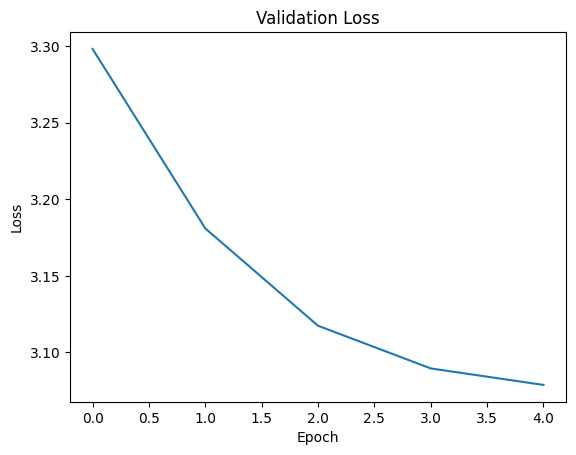

In [ ]:
# prompt: plot the validation loss

val_loss = [trainer.state.log_history[i]['eval_loss'] for i in range(5)]
plt.plot(val_loss)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
trainer.evaluate()

{'eval_loss': 3.07879900932312,
 'eval_rouge1': 0.2605,
 'eval_rouge2': 0.1128,
 'eval_rougeL': 0.2279,
 'eval_rougeLsum': 0.2259,
 'eval_gen_len': 54.6944,
 'eval_runtime': 23.5689,
 'eval_samples_per_second': 3.055,
 'eval_steps_per_second': 0.382,
 'epoch': 5.0}

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()

## Check How It Worked on Test Data

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
num_examples = 10
random_indices = np.random.choice(len(tokenized_dataset['test']), num_examples, replace=False)
print(random_indices)

[ 4 62 18  0 28 50 10 34 12 54]


In [ ]:
#specify compute device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#set format to Torch
tokenized_dataset['test'].set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
batch_size = 10 #note that the standard batch size for the DataLoader is 200
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size = batch_size)

In [ ]:
summarized_texts = []
for batch in iter(test_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 100
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_dataset['test']['abstract']
claims_results = rouge.compute(predictions=predictions,
                        references=references)
print(claims_results)

{'rouge1': 0.17598323412883976, 'rouge2': 0.054219709979095844, 'rougeL': 0.1509662225037125, 'rougeLsum': 0.15035918739693255}


In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [tokenized_dataset['test']['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,<pad> The present invention relates to oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotides and methods of using oligonucleotide</s>,"Described are compounds and methods useful for the treatment and investigation of diseases and disorders associated with expanded repeat-containing RNA molecules. In certain embodiments, compounds and methods useful for the modulation of ATXN-3 pre-mRNA are described. In certain embodiments, compounds and methods useful for the modulation of ATN-1 mRNA are described."
1,"<pad> The present invention relates to the use of polynucleotides for the synthesis of collagen, and more particularly to the use of polynucleotides for the synthesis of collagen. The present invention also relates to the use of polynucleotides for the synthesis of collagen, and more particularly to the use of polynucleotides for the synthesis of collagen. The present invention also relates to the use of polynucleotides for the synthesis of collagen, and more particularly to the use of polynucleotides for the synthesis</s>","The present invention relates to a fusion protein comprising a skin-penetrating peptide, a polynucleotide encoding the fusion protein, an expression vector comprising the polynucleotide, a transformant comprising the expression vector, a method for preparing the fusion protein, a cosmetic composition for improving skin conditions, which comprises the fusion protein, and a pharmaceutical composition for external skin use, which comprises the fusion protein. The fusion protein of the invention comprises a skin-penetrating peptide bound to a physiologically active protein. The fusion protein significantly enhances the skin penetration and skin retention of the physiologically active protein while maintaining or enhancing the ability of the physiologically active protein to synthesize a material showing physiologically active effects. Thus, it can be widely used as an active ingredient in functional cosmetic compositions and pharmaceutical compositions for external skin use."
2,<pad> The present invention relates to heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl alkyl compounds and methods of making them. The present invention provides heteroalkyl </s>,"The present invention provides compositions and methods for the selective C—H fluorination of nitrogen-containing heteroarenes with AgF2, which has previously been considered too reactive for practical, selective C—H fluorination. Fluorinated heteroarenes are prevalent in numerous pharmaceuticals, agrochemicals and materials. However, the reactions used to introduce fluorine into these molecules require pre-functionalized substrates or the use of F2 gas. The present invention provides a mild and general method for the C—H fluorination of nitrogen-containing heteroarene compounds to 2-fluoro-heteroarenes with commercially available AgF2. In various embodiments, these reactions occur at ambient temperature within one hour and occur with exclusive selectivity for fluorination at the 2-position. Exemplary reaction conditions are effective for fluorinating diazine heteroarenes to form a single fluorinated isomer."
3,"<pad> The present

Observations:
* Rouge scores are disappointingly bad... why?
* The model seems to be getting stuck looping through the same phrase over and over again.
* Summaries refer to formulas with IDs that are not there...